**MITx 6.419x  Data Analysis: Statistical Modeling and Computation in Applications**  
Written report -- Homework 5  
Student Name (Xing Zhang)  
5/31/21  
---

## Module 5: Environmental Data and Gaussian Processes

### Part I - Ocean Flow

### Problem 2: Identifying long-range correlations

**1.** In this problem, we will try to identify areas in the Philippine Archipelago with long-range correlations. Your task is to identify two places on the map that are not immediately next to each other but still have some high correlation in their flows. Your response should be the map of the Archipelago with the two areas marked (e.g., circled). You claim that those two areas have correlated flows. Explain how you found that those two areas have correlated flows.

- (5 points): A map with the two points with correlations marked.  
- (3 points): Provides an explanation of how the correlation was computed.  
- (2 points): Provides a convincing commentary on why the two marked locations could be correlated.

### Solution:

Here, we will judge the correlation from two aspects: the total flow velocity value and the variance of the flow velocity change.

The tatal flow velocity $v = \sqrt {(V^2 + U^2)}$
The variance of the flow velocity change over the time can be calculated by

In [2]:
np.mean()

NameError: name 'np' is not defined

The two points marked in the figure have highly correlate on flow velocity and variances. From the geographical location in the figure, it can be found that the two locations are in the strait. When the sea water passes through the narrow land channel, the pressure causes the flow velocity to increase. Due to the influence of tidal forces, the flow direction at this location also varies greatly, so the flow velocity variance It's also very big.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from math import sqrt
import math

mask = np.loadtxt("OceanFlow/mask.csv", delimiter=',')
mask = np.flip(mask,0)
v_40 = np.loadtxt("OceanFlow/40v.csv", delimiter=',')
num_row,num_col = v_40.shape
U = np.zeros((num_row, num_col, 100))
V = np.zeros((num_row, num_col, 100))
SPEED = np.zeros((num_row, num_col, 100))

for i in range(100):
    filename_u = "OceanFlow/" + str(i+1) + "u.csv"
    U[:,:,i] = np.loadtxt(filename_u, delimiter=',')
    U_m = U*25/0.9/100
    filename_v = "OceanFlow/" + str(i+1) + "v.csv"
    V[:,:,i] = np.loadtxt(filename_v, delimiter=',')
    V_m = V*25/0.9/100
    SPEED[:,:,i] = np.sqrt( U_m[:,:,i]**2 + V_m[:,:,i]**2)
    
U_var = np.var(U*25/0.9,axis =2)
V_var = np.var(V*25/0.9,axis =2)
log_var = np.log(1+U_var+V_var)


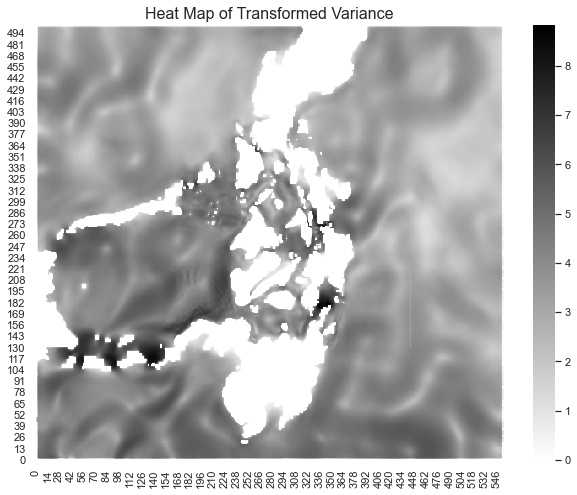

In [6]:
plt.figure(figsize=(10.5, 8))
ax_var = sns.heatmap(log_var, cmap = 'binary')
ax_var.invert_yaxis()
plt.title("Heat Map of Transformed Variance", size = 16)
plt.savefig('variance')
plt.show()

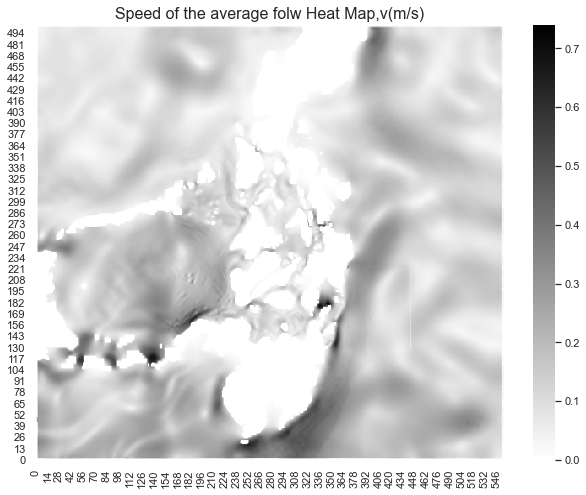

In [7]:
plt.figure(figsize=(10.5, 8))
speed_mean_cmps = np.mean(SPEED, axis=2)
ax_speed = sns.heatmap(speed_mean_cmps,cmap="binary")
ax_speed.invert_yaxis()
plt.title('Speed of the average folw Heat Map,v(m/s)', size = 16)
plt.savefig('speed')
plt.show()

### Problem 3: Simulating particle movement in flows
In this problem, you are asked to build a simulator that can track a particle's movement on a time-varying flow.

**a.** We assume that the velocity of a particle in the ocean, with certain coordinates, will be determined by the corresponding water flow velocity at those coordinates. Implement a procedure to track the position and movement of multiple particles as caused by the time-varying flow given in the data set. Explain the procedure, and show that it works by providing examples and plots.  

Draw particle locations uniformly at random across the entire map, do not worry if some of them are placed on land. Simulate the particle trajectories for 300 hours and provide a plot of the initial state, a plot of the final state, and two plots at intermediate states of the simulation. You may wish to draw colors at random for your particles in order to help distinguish them.

- (3 points): Provides an explanation of the simulation algorithm, with equations for the evolution of the particle trajectory.  
- (2 points): Provides a plot of the initial state of the simulation.  
- (3 points): Provides two plots of intermediate states of the simulation.  
- (2 points): Provides a plot of the final state of the simulation.

### Solution:
Explanation of the simulation algorithm:
>A flow refers to displacement in time, that is if $x(t)$ denotes the location of a particle at time $t$. Then, we define the flow vector as
\begin{equation}
 \frac{d x(t)}{dt}= V(x(t),t).
\end{equation}
or similarly, their explicit Euler discretization as, for a small $\varepsilon > 0$ , then
\begin{equation}
  x(t+\varepsilon) = x(t) + \varepsilon V(x(t),t).
\end{equation}
Informally, if we know the position of a particle at time $t$, then, after some arbitrarily small time $\varepsilon$, that is, at time $t+\varepsilon$, we can compute the new position $x(t+\varepsilon)$ as $x(t+\varepsilon) = x(t) + \varepsilon V(x(t),t)$, assuming we know the flow information coded in the function $V(x(t),t)$.
The next figure shows a simple flow system with four points, shown as white circles. Each point corresponds to a physical location also shown in kilometers. Attached to each point is a flow data point, which is shown as a blue arrow. Recall that flow data is given in the $x$ and $y$ direction. It is assumed that a particle moving in one of the zones or boxes acquires the velocity given by the flow data.

>As noted by the description above, in order to simulate the movement of the particle we need a couple of items:
- A space $\mathcal{X}$ where we want out simulation to be run on. For example for a 2-dimensional space, we can consider a box with unitary lenght, i.e., $\mathcal{X}=[0,1]\times[0,1]$.
- An initial position $x(0)\in\mathcal{X}$. Of course we want our initial position to be inside the space we want to simulate the movement.
- A simulation time $T$. This is the maximum time we would like to run our simulation.
- A time step $T\geq\varepsilon>0$. The unit $\varepsilon$ is going to serve as a discretization of time, and is going to the the smallest unit of time we are going to consider in our simulation. In practice, this means our simulation should output a sequence of positions for times $\{0,\varepsilon,2\varepsilon,3\varepsilon,4\varepsilon,\ldots,T\}$.
- The number $\varepsilon$ also defines the number of iterations we are going to have in our simulation. For example, if $T=10$, and $\varepsilon=2$, then we will run a total of $N=5$ iterations. One can start the oposite direction, by defining the number of iterations first and then compute the corresponding time step. For example, if I want to run $N=300$  iterations, I will have to set \begin{equation} \varepsilon = \frac{T}{N} = \frac{10}{300} \approx 0.033.\end{equation}
- A flow function $V(x(t),t) : \mathcal{X} \times [0, T] \rightarrow \mathbb{R}^2$. This function has two input arguments, namely, a position $x(t)$ and a time $t$, and outputs a vector in $\mathbb{R}^2$ which indicates the velocity that a particle at location $x(t)$ would have in the $x$ and $y$ axis respectively. Note that we have explicitly allowed the flow function to depend on time. That is, flows might change depending not only on the location but of the time index.
- In general, we might not have access to a generic function of the form $V(x(t),t) : \mathcal{X} \times [0, T] \rightarrow \mathbb{R}^2$, specially if our flow comes from data that has been obtained at some particular set of locations. In this case, we might consider a set $\mathcal{G} = \{x_1, x_2, \ldots, x_m\}$ where $x_i\in\mathcal{X}$ for $i\in\{1,2,\ldots,m\}$. These points represents the locations where flow information is available. For simulation purposes in this case, if at some point in time $t \in [0, T]$, the particle is at a location $x(t)$, instead of using the flow $V(x(t),t)$ which might not be available, we will use the surrogate flow $V(x_j,t)$ where $x_j = \mathrm{argmin}_{z\in\mathcal{G}} \;d(z, x(t))$ where $d(\cdot,\cdot)$ is some distance function, for example $d(x,y) = \|x - y\|^2$. This indicates that we will use the flow information at a point $x_j$ in the set of available locations, that is closest to $x(t)$ in some predefined sense.

The trajectory is shown in the figure below, and the red mark is the end position at the corresponding time

In [10]:
M, L = mask.shape
#initialize particle's location (X,Y)
#location = (y,x)

def get_random_location():
    '''
    make sure location is in the sea
    '''
    location = (np.random.uniform(0,M), np.random.uniform(0,L) )
    y = int(math.floor(location[0]))
    x = int(math.floor(location[1]))
    while mask[y,x] == 0:
        location = ( np.random.uniform(0,M), np.random.uniform(0,L) )
        y = int(math.floor(location[0]))
        x = int(math.floor(location[1]))
    return location
        
def get_velocity(loc,t):
    '''
    given location and time t, return the u and v as a tuple for this paricle.
    unit is m/second
    '''
    y = int(math.floor(loc[0]))
    x = int(math.floor(loc[1]))
    u = U[y,x,t]*25/0.9/100
    v = V[y,x,t]*25/0.9/100
    return (u,v)

def move(loc, stepsize_t, t):
    '''
    the unit of stepsize_t is second.
    an hour = 3600 seconds.
    '''
    y = loc[0]
    x = loc[1]
    u,v = get_velocity(loc,t) # unit = m/s
    return (y+v*stepsize_t/3000, x+u*stepsize_t/3000)

def plot_trajectory(init_loc, end_loc, stepsize_t, maxtimes):
    '''
    max times unit is an hour
    '''
    ax = sns.heatmap(data = mask,cbar = False,cmap='Greys_r')
    ax.invert_yaxis()
    y,x = init_loc
    times= 0
    x_list = []
    y_list = []
    while times<maxtimes:
        interval_times = int(math.floor(times/3))
        y, x = move((y,x), stepsize_t, interval_times); #freeze time now
        x_list.append(x)
        y_list.append(y)
        times+=stepsize_t/3600
    scatter = plt.plot(x_list, y_list, marker='o', markersize=1, color="blue")
    plt.plot(x_list[-1],y_list[-1],marker='o', markersize = 5, color = 'red')

def plot_trajectory_random(end_loc, stepsize_t, maxtimes, n, m):
    '''
    max times unit is an hour
    '''
    x_list = {}
    y_list = {}
    for i in range(n):
        y,x = get_random_location()
        times= 0
        x_list[i] = []
        y_list[i] = []
        while times<maxtimes:
            interval_times = int(math.floor(times/3))
            y, x = move((y,x), stepsize_t, interval_times); #freeze time now
            x_list[i].append(x)
            y_list[i].append(y)
            times+=stepsize_t/3600
    for j in range(m+1) :
        plt.figure(figsize=(10.5,8))
        ax = sns.heatmap(SPEED[:,:,int(maxtimes/3/m*j-1)], cmap="binary")
        ax.invert_yaxis()
        for i in range(n):
             scatter = plt.plot(x_list[i][0:int((j)*maxtimes/m)], y_list[i][0:int((j)*maxtimes/m)], marker='.', markersize=0.01, color="blue")
             plt.plot(x_list[i][int((j)*maxtimes/m)-1],y_list[i][int((j)*maxtimes/m)-1],marker='o', markersize = 2, color = 'red')
        plt.title("Speed Heat Map in time:"+str(int(maxtimes/m*(j)))+'hours',size = 16)
    
def plot_speedmap(maxtimes):
    ax = sns.heatmap(SPEED[:,:,int(maxtimes/3-1)], cmap="binary")
    ax.invert_yaxis()

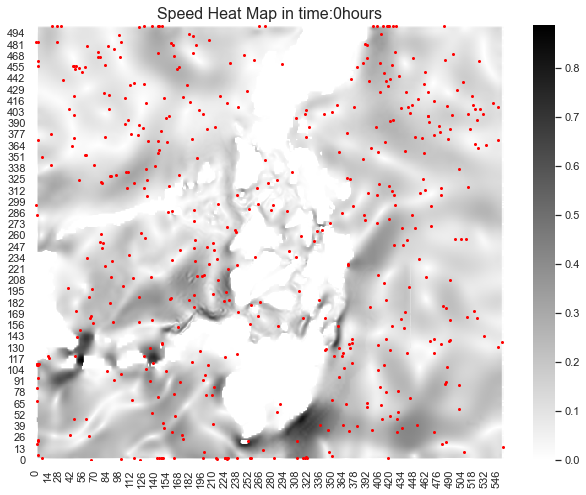

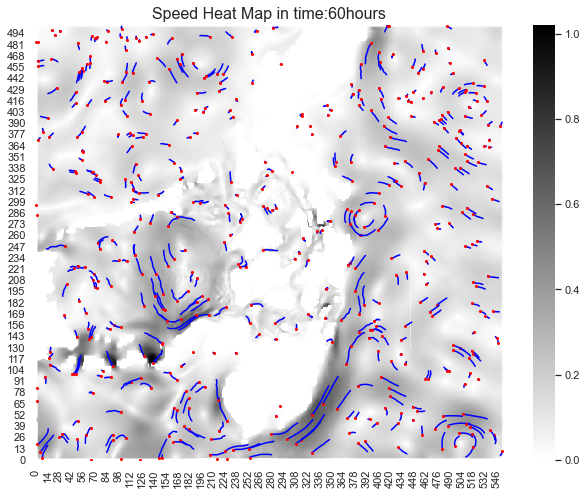

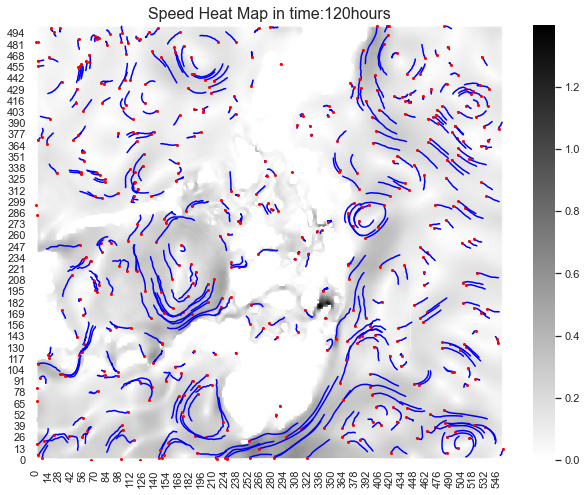

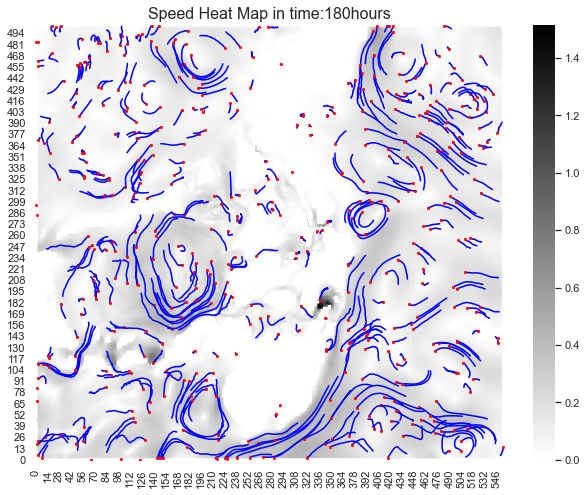

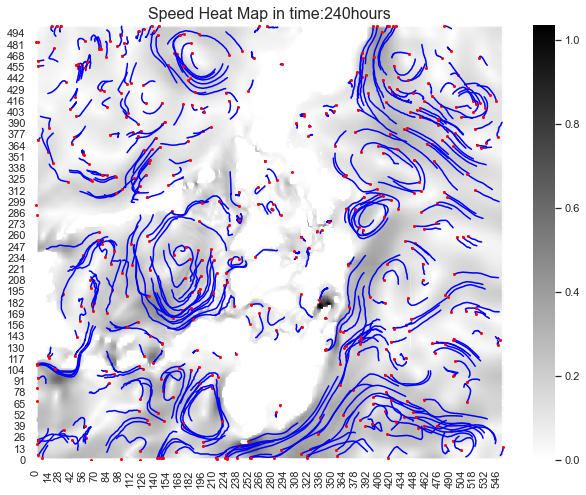

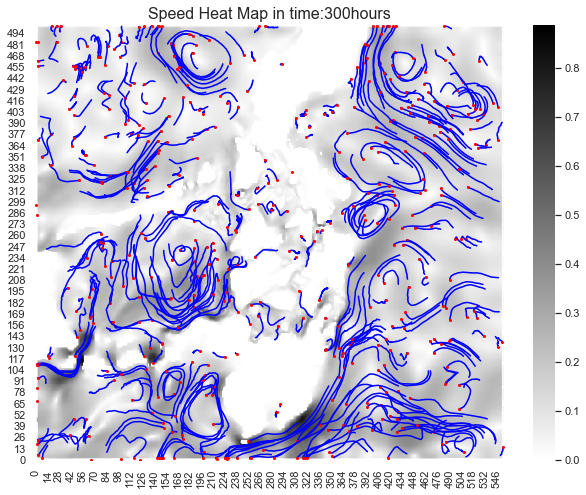

In [11]:
plot_trajectory_random((200,200),3600, 300, 500, 5)

**b.** A (toy) plane has crashed in the Sulu Sea at $T=0$. The exact location is unknown, but data suggests that the location of the crash follows a Gaussian distribution with mean $(100,350)$ (namely $(300km,1050km)$) with variance $\sigma^2$. The debris from the plane has been carried away by the ocean flow. You are about to lead a search expedition for the debris. Where would you expect the parts to be at $48$hrs, $72$hrs, $120$hrs? Study the problem by varying the variance of the Gaussian distribution. Either pick a few variance samples or sweep through the variances if desired. (Hint: Sample particles and track their evolution.)

- (3 points): Provides plots showing the state of the simulation at the times: T=48hrs, 72hrs, 120hrs. (Three plots required.)  
- (3 points): Two or more additional choices of the variances were tried, and three plots of the state of the simulation at the above three times are provided. (Six additional plots required.)  
- (4 points): Comments on where one should concentrate search activities based on the observed results.

### Solution:
(1)The red mark represents the end position of the toy plane drifting after a period of time.$\sigma^2$=10

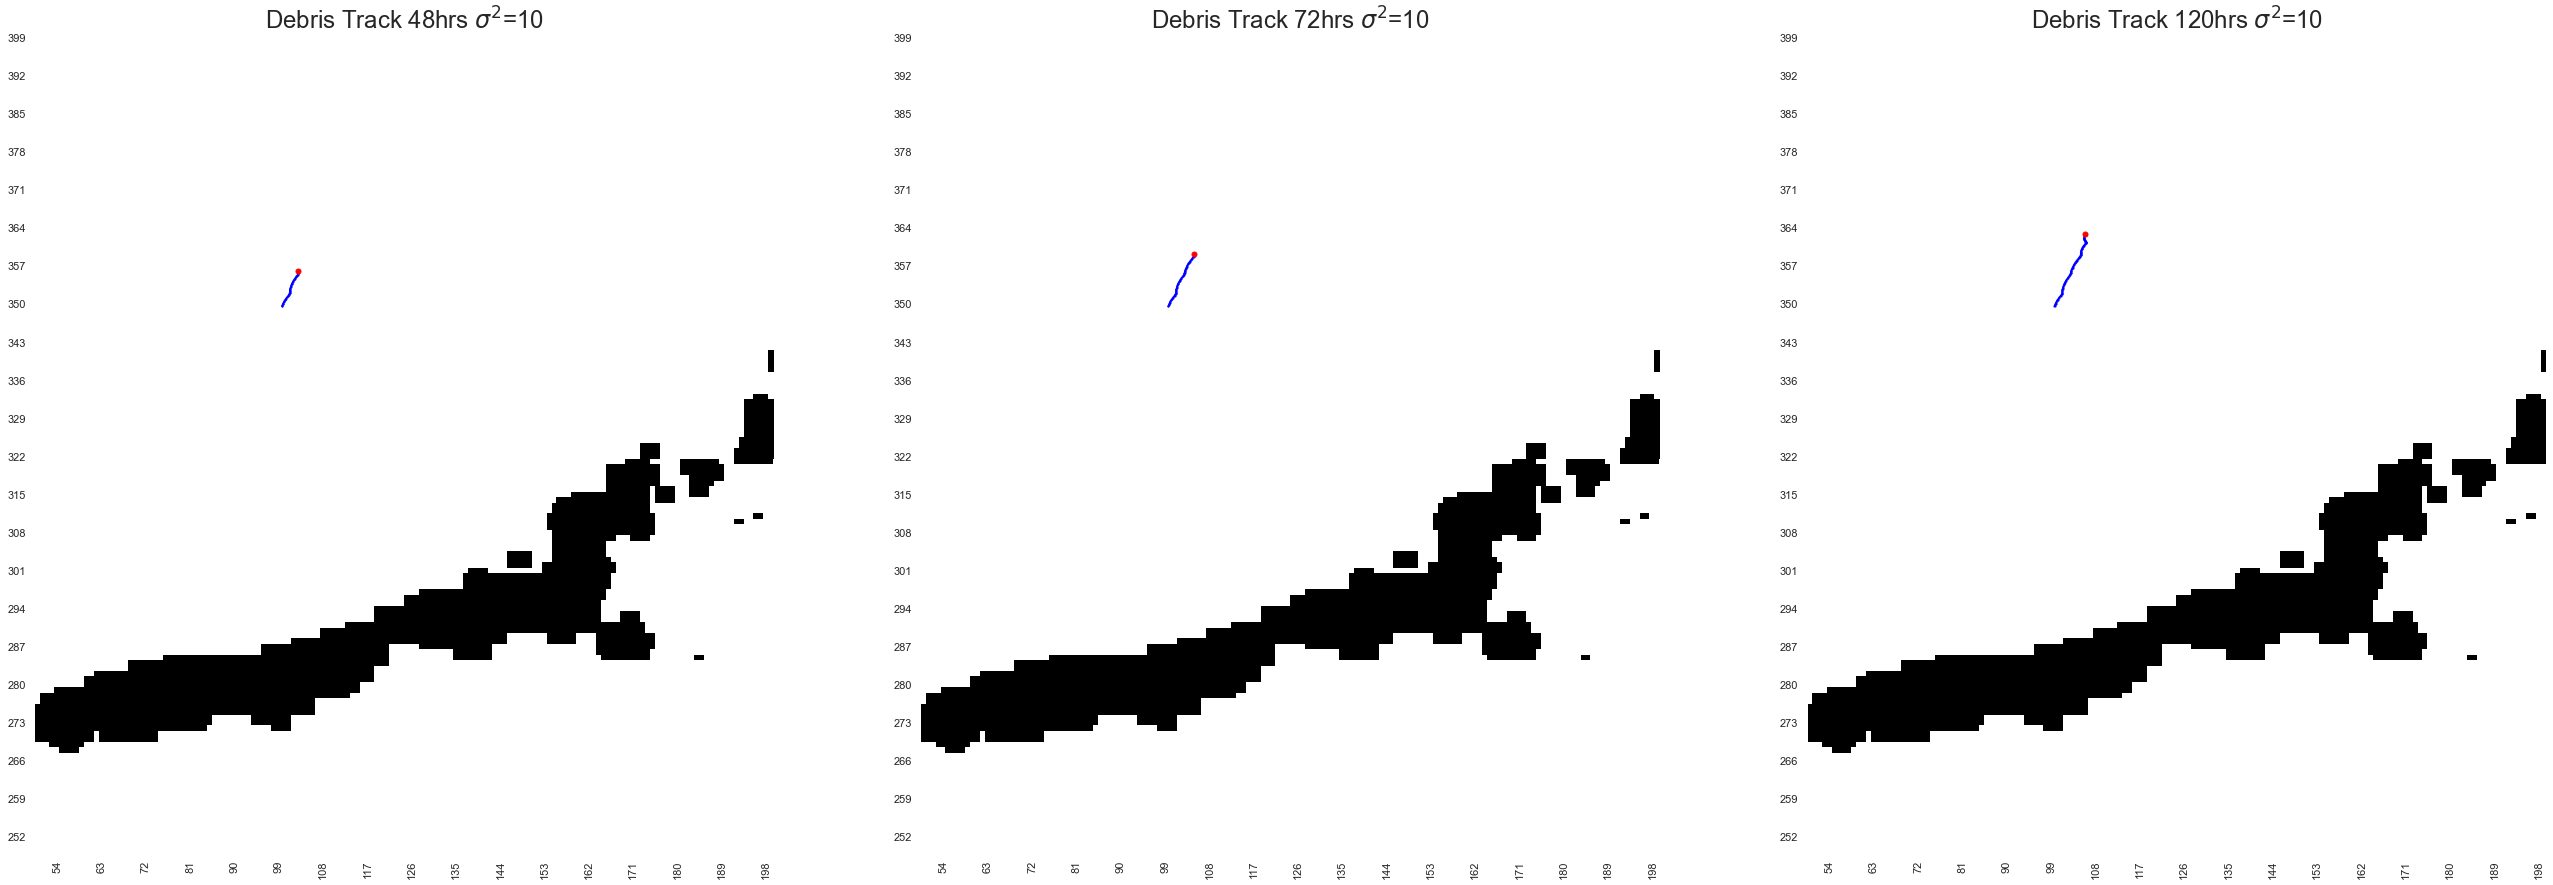

In [12]:
def get_normal_random(sigma_square):
    '''
    return a random location based on normal distruibution, (y,x)
    '''
    sigma = math.sqrt(sigma_square)
    y = np.random.normal(350, sigma)
    x = np.random.normal(100,sigma)
    return (y,x)

crush_location = get_normal_random(10)
plt.figure(figsize=(45,15))
plt.subplot(1,3,1)
plot_trajectory(crush_location,(200,200),3600,48)
plt.axis((50,200,250,400))
plt.title('Debris Track 48hrs $\sigma^2$=10',size = 24)

plt.subplot(1,3,2)
plot_trajectory(crush_location,(200,200),3600,72)
plt.axis((50,200,250,400))
plt.title('Debris Track 72hrs $\sigma^2$=10',size = 24)

plt.subplot(1,3,3)
plot_trajectory(crush_location,(200,200),3600,120)
plt.axis((50,200,250,400))
plt.title('Debris Track 120hrs $\sigma^2$=10', size= 24)
plt.show()

(2)The red mark represents the end position of the toy plane drifting after a period of time.$\sigma^2$=50,100.

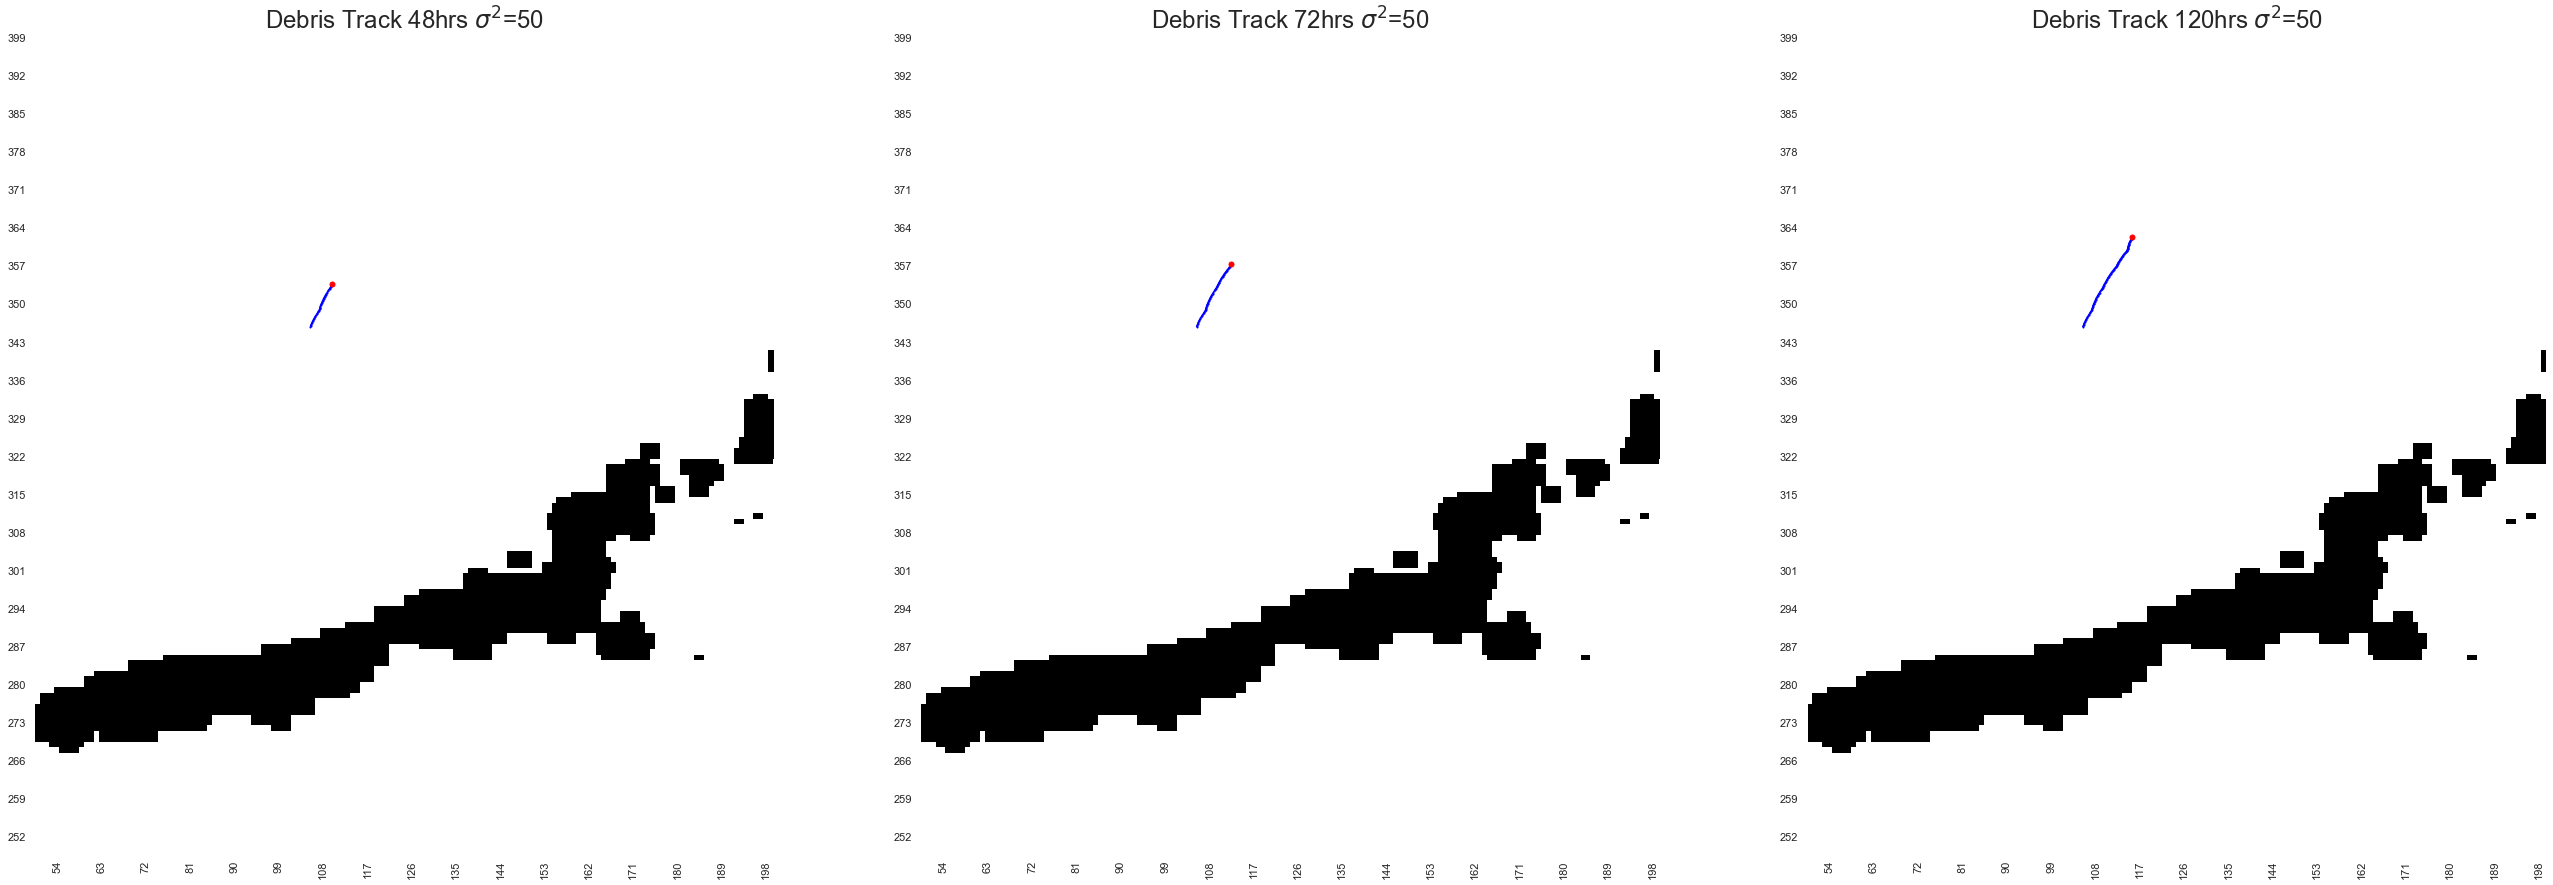

In [13]:
get_normal_random(50)

crush_location = get_normal_random(50)
plt.figure(figsize=(45,15))
plt.subplot(1,3,1)
plot_trajectory(crush_location,(200,200),3600,48)
plt.axis((50,200,250,400))
plt.title('Debris Track 48hrs $\sigma^2$=50',size = 24)

plt.subplot(1,3,2)
plot_trajectory(crush_location,(200,200),3600,72)
plt.axis((50,200,250,400))
plt.title('Debris Track 72hrs $\sigma^2$=50',size = 24)

plt.subplot(1,3,3)
plot_trajectory(crush_location,(200,200),3600,120)
plt.axis((50,200,250,400))
plt.title('Debris Track 120hrs $\sigma^2$=50', size= 24)
plt.show()

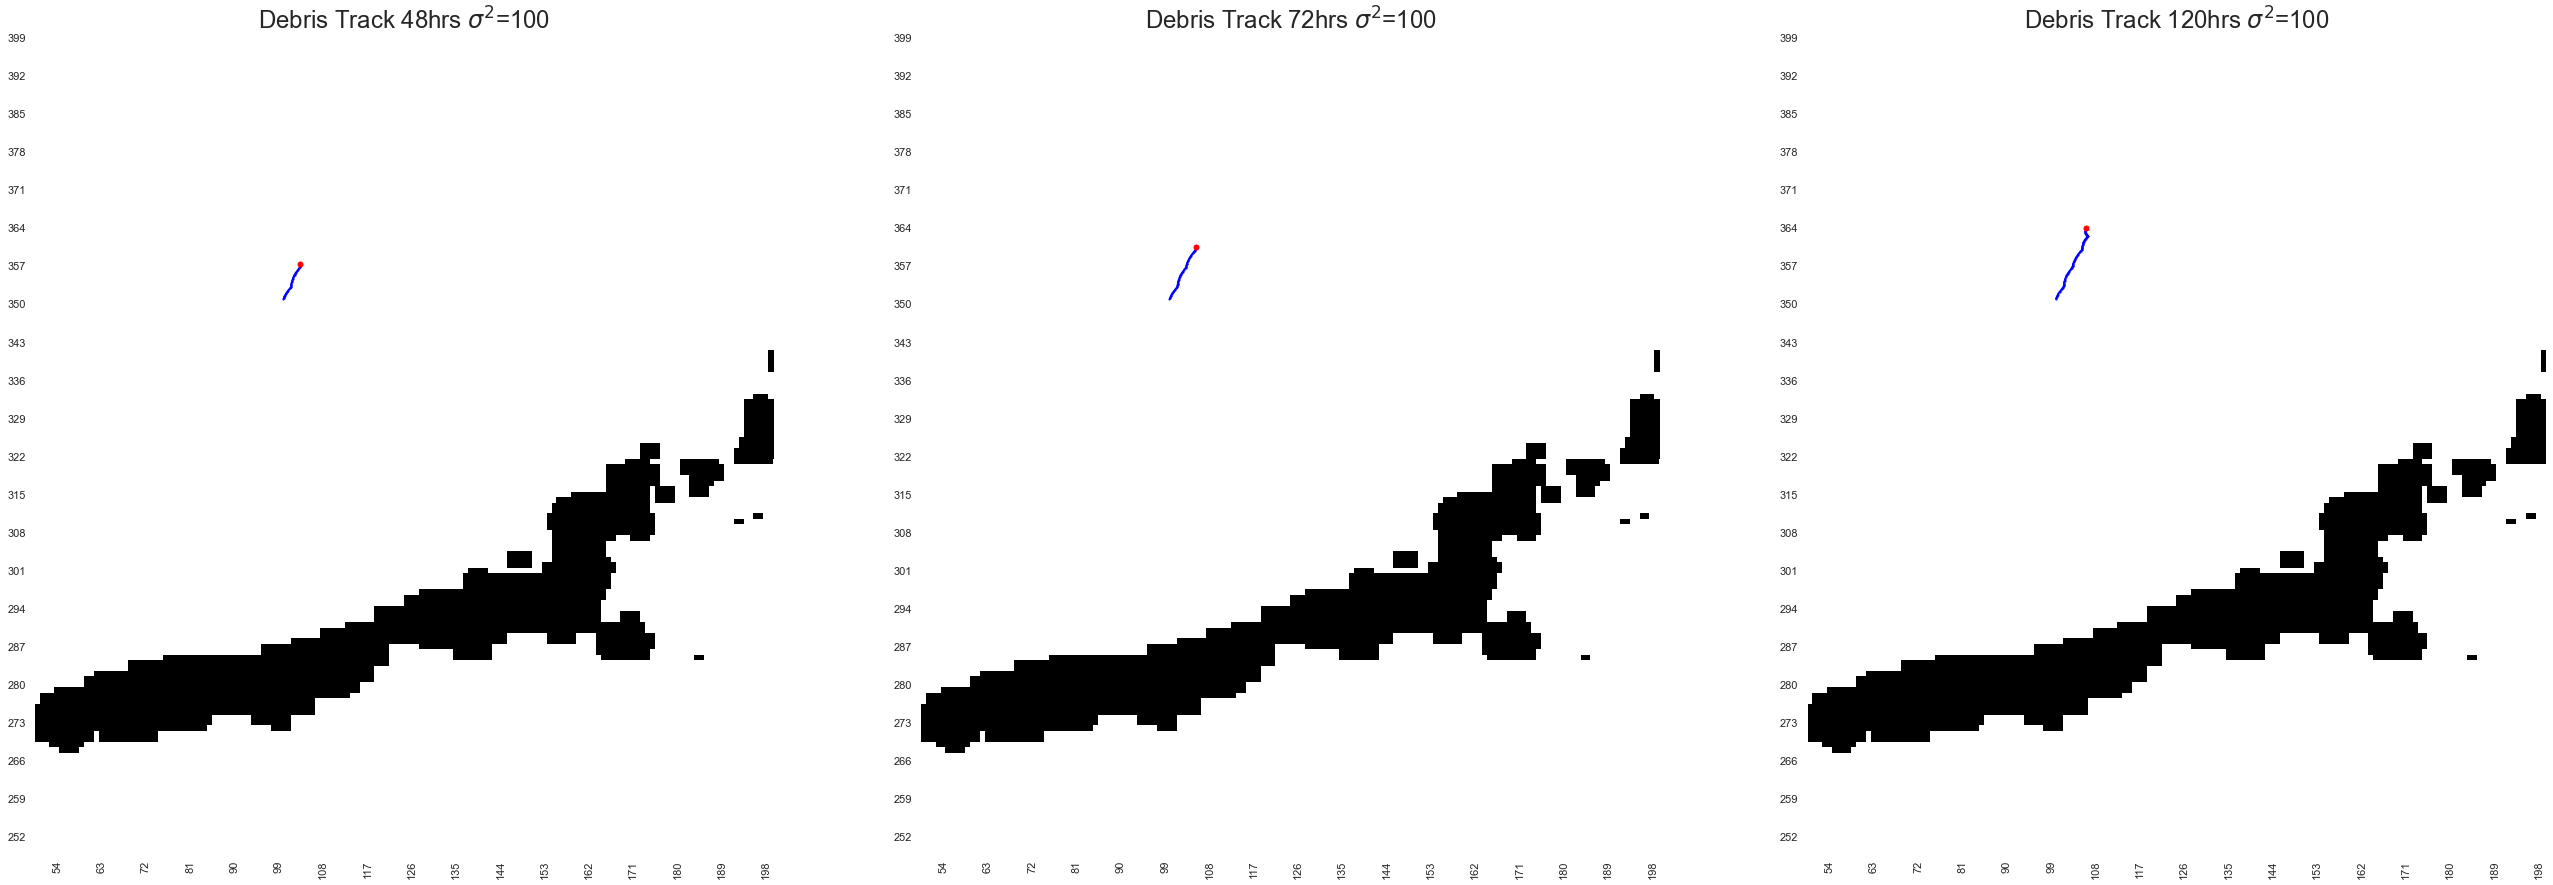

In [14]:
get_normal_random(100)

crush_location = get_normal_random(100)
plt.figure(figsize=(45,15))
plt.subplot(1,3,1)
plot_trajectory(crush_location,(200,200),3600,48)
plt.axis((50,200,250,400))
plt.title('Debris Track 48hrs $\sigma^2$=100',size = 24)

plt.subplot(1,3,2)
plot_trajectory(crush_location,(200,200),3600,72)
plt.axis((50,200,250,400))
plt.title('Debris Track 72hrs $\sigma^2$=100',size = 24)

plt.subplot(1,3,3)
plot_trajectory(crush_location,(200,200),3600,120)
plt.axis((50,200,250,400))
plt.title('Debris Track 120hrs $\sigma^2$=100', size= 24)
plt.show()

(3) Draw the search range of random falling locations with a variance value of 1-100. The red dots are the drifting end positions after a period of time. The toy plane should be found in the area enclosed by these red dots.

In [15]:
def plot_trajectory_toy(stepsize_t, maxtimes, n):
    '''
    max times unit is an hour
    '''   
    x_list = {}
    y_list = {}
    for i in range(n):
        y,x = get_normal_random(i)
        times= 0
        x_list[i] = []
        y_list[i] = []
        while times<maxtimes:
            interval_times = int(math.floor(times/3))
            y, x = move((y,x), stepsize_t, interval_times); #freeze time now
            x_list[i].append(x)
            y_list[i].append(y)
            times+=stepsize_t/3600
    
    for j in range(6) :
        if j<=1:continue
        else:
            plt.figure(figsize=(8,8))
            ax = sns.heatmap(data = mask,cbar = False,cmap='Greys_r')
            ax.invert_yaxis() 
            for i in range(n):
                 scatter = plt.plot(x_list[i][int(24*j)-1],y_list[i][int(24*j)-1],marker='o', markersize = 5, color = 'red')
            plt.axis((50,200,250,400))
            plt.title('Debris Track'+str(j*24)+'hours',size = 16)        

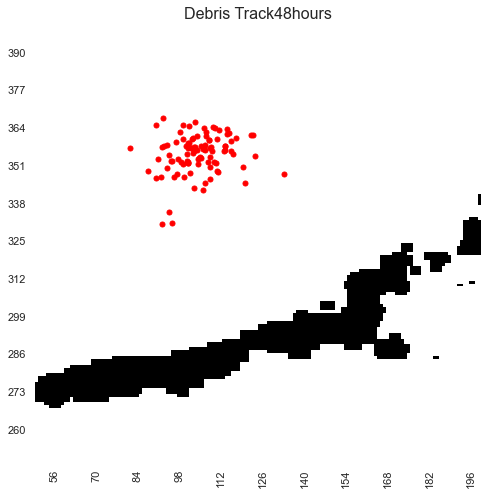

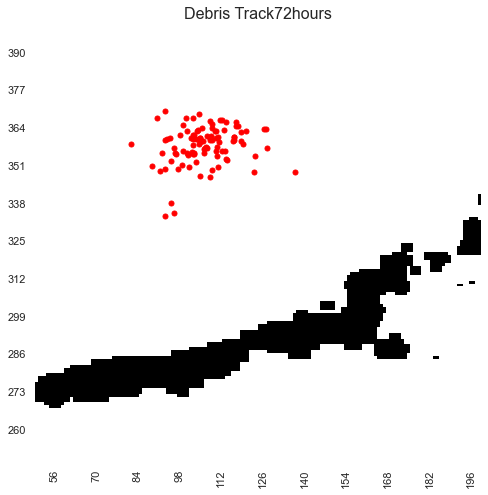

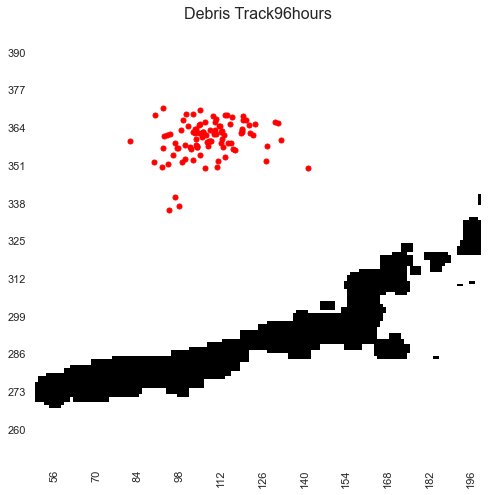

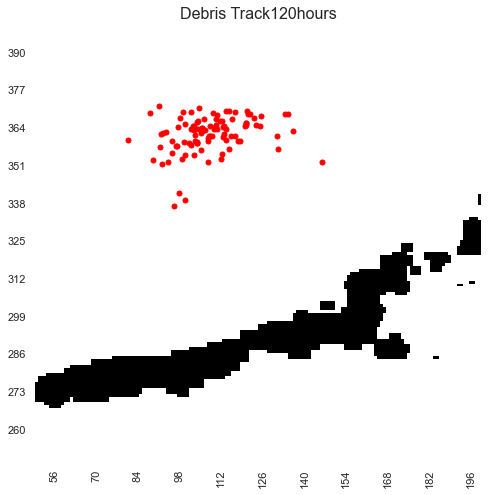

In [16]:
plot_trajectory_toy(3600, 120, 100)

### Part II - Estimating Flows with Gaussian Processes

### Problem 4: Creating a Gaussian process model for the flow
In this problem, we will create a Gaussian process model for the flow given the information we have.

**a.** Pick a location of your liking from the map for which you are given flow data (ideally from a location on the ocean not in the land). Moreover, consider the two vectors containing the flow speed for each direction: you will end up with two vectors of dimension $100$.  

You are asked to find the parameters of the kernel function that best describes the data independently for each direction.

- (1 point): States the choice of kernel function and provides a justification for this choice.  
- (1 point): Identifies the parameters of the kernel function.  
- (1 point): Explicitly states the search space for each kernel parameter.  
- (1 point): Explicitly states the number of folds (k) for the cross-validation.  
- (3 points): Provides the optimal kernel parameters from the search.  
- (3 points): Provides a plot of the computed cost/performance metric over the search space for the kernel parameters.

### ANS
Select the coordinate point at (x, y) = (320, 25)

(1) pick the  kernel function:
\begin{equation}
  k(z_1,z_2) = a \times \exp{\left(- \frac{\| z_1 - z_2 \|}{2 l^2}\right)}.
\end{equation}
The selected kernel function depends on a "distance" between the random variables at hand. In this case, each random variable represents the velocity. Of couse, this distance is in the time variable. 

(2) For the selected kernel function, we can identify the set of parameters $\theta=(a,l)$.

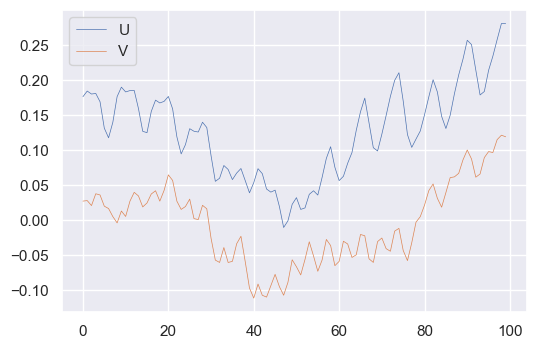

In [7]:
import numpy as  np
import matplotlib.pyplot as plt
plt.close()
plt.clf()
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

U_dot = U_m[319,24,:]
V_dot = V_m[319,24,:]
x = np.arange(100)
plt.plot(x, U_dot, label="U", lw=0.5)
plt.plot(x, V_dot, label="V", lw=0.5)
plt.legend()
plt.show()


(3) This case pick U as the data. Search space: a:[0,0.3,0.01],l:[7,360,0.1]

(4) The number of folds (k) = 5 for the cross-validation.

(5) The optimal kernel parameters from the search: a = 0.01; l= 14.92

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 19.35it/s]


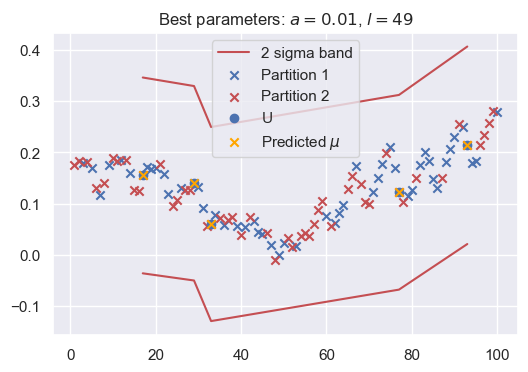

In [14]:
import numpy.linalg as lalg
import scipy.stats
import tqdm



for k_x2, label, c in [(k1_x2, "Partition 1", 'b'), (k2_x2, "Partition 2", 'r')]:
  plt.scatter(k_x2+1, U_dot[k_x2], label=label, c=c, marker='x')

theta1 = 0.1 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta2 = 50 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta3 = 0.97 #@param {type:"slider", min:0, max:4, step:0.01}

covs = np.arange(1,101)[:,None] - np.arange(1,101)[None,:]
a_vals = np.arange(0.0, 0.3, 0.01)
ell_vals = np.arange(7, 50, 1)

ind_x2 = np.arange(0, 100, 4)

K = 5
perm = np.random.permutation(ind_x2.shape[0])
ks_x2 = [ ind_x2[a] for a in map(np.sort, np.array_split(perm, K)) ]

tau = 1.0

target_best = -np.inf
params_best = {}

for a_param in tqdm.tqdm(a_vals):
  for ell_param in ell_vals:
    sigma = a_param * np.exp( - covs**2 / ell_param**2 )

    vals = []
    
    for k in range(K):
      x_test = ks_x2[k]
      x_train = np.sort(np.array(list(set(ind_x2) - set(x_test))))

      mu_1 = U_dot[x_test]
      mu_2 = U_dot[x_train]

      sigma_11 = sigma[x_test[:,None],x_test]
      sigma_12 = sigma[x_test[:,None],x_train]
      sigma_21 = sigma[x_train[:,None],x_test]
      sigma_22 = sigma[x_train[:,None],x_train]

      sigma_22_noise = sigma_22 + tau * np.eye(mu_2.shape[0])
      x2_2 = U_dot[x_train]

      mu_1_2 = mu_1 + sigma_12.dot( lalg.solve(sigma_22_noise, x2_2 - mu_2 ) )
      sigma_1_2 = sigma_11 - sigma_12.dot(np.linalg.solve((sigma_22_noise), np.eye(sigma_22_noise.shape[0])).dot(sigma_12.T))

      val = scipy.stats.multivariate_normal.logpdf(U_dot[x_test], mean=mu_1_2, cov=sigma_1_2,allow_singular=True)
      vals.append(val)

    total = sum(vals)

    if total > target_best:
      params_best = dict(
          a=a_param,
          ell=ell_param,
          xs=x_test+1,
          U_dot=U_dot[x_test],
          mu=mu_1_2,
          sigma=np.sqrt(np.diagonal(sigma_1_2))
      )
      target_best = total

sigma_opt = params_best['a'] * np.exp( - covs**2 / params_best['ell']**2 )
plt.scatter(params_best['xs'], params_best['U_dot'], c='b', marker='o', label="U")
plt.scatter(params_best['xs'], params_best['mu'], c='orange', marker='x', label=r"Predicted $\mu$")
plt.plot(params_best['xs'], params_best['mu'] + 2*params_best['sigma'], c='r', label="2 sigma band")
plt.plot(params_best['xs'], params_best['mu'] - 2*params_best['sigma'], c='r')
plt.title(r"Best parameters: $a={a}$, $l={ell}$".format(**params_best))
plt.legend()
plt.show()

**b.** Run the process described in the point (a) for at least three more points in the map, you free to choose more if you wish. What do you observe? Which of your kernel parameters show patterns? Which do not?

- (3 points): Provides the optimal kernel values for three new location that are different from the location in Problem 4.a. (Plots do not need to be provided.)  
- (2 points): For each kernel parameter, states if a pattern was observed.

(1) The optimal kernel values are as follows:\
    location[219,24]: a1 = 0.01; l1 = 17;\
    location[319,324]: a2 = 0.01; l2 = 18;\
    location[500,400]: a3 = 0.01; l3 = 14;

(2)It can be found that when the distribution of flow is flatter, the value of l is larger, and the value of a is related to the maximum or minimum value of flow.

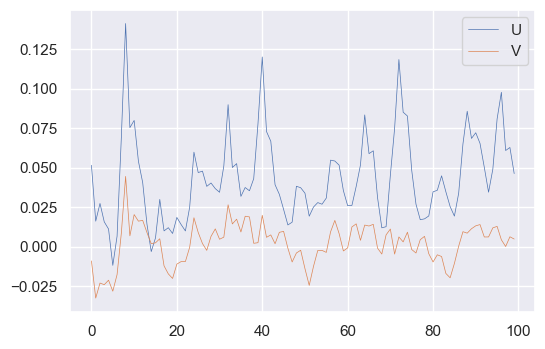

In [42]:
import numpy as  np
import matplotlib.pyplot as plt
import numpy.linalg as lalg
import scipy.stats
import tqdm

plt.close()
plt.clf()
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

U_dot1 = U_m[119,224,:]
V_dot1 = V_m[119,224,:]
x = np.arange(100)
plt.plot(x, U_dot1, label="U", lw=0.5)
plt.plot(x, V_dot1, label="V", lw=0.5)
plt.legend()
plt.show()

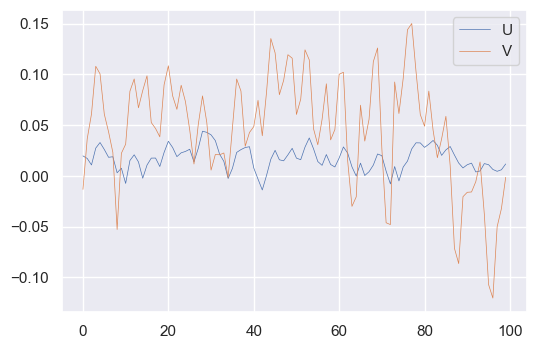

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:29<00:00,  1.01it/s]


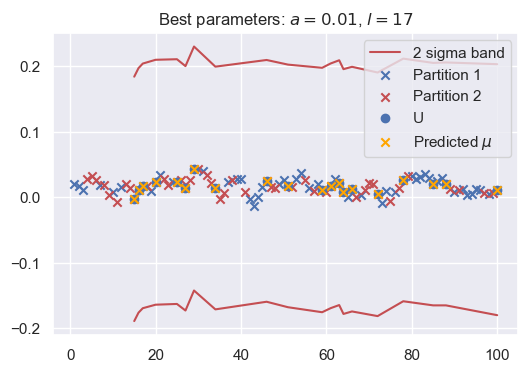

In [43]:
import numpy as  np
import matplotlib.pyplot as plt
import numpy.linalg as lalg
import scipy.stats
import tqdm

plt.close()
plt.clf()
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

U_dot = U_m[219,24,:]
V_dot = V_m[219,24,:]
x = np.arange(100)
plt.plot(x, U_dot, label="U", lw=0.5)
plt.plot(x, V_dot, label="V", lw=0.5)
plt.legend()
plt.show()

ind_x2 = np.arange(0,100,1)
perm = np.random.permutation(ind_x2.shape[0])
k1_x2, k2_x2 = [ ind_x2[a] for a in map(np.sort, np.split(perm, 2)) ]

for k_x2, label, c in [(k1_x2, "Partition 1", 'b'), (k2_x2, "Partition 2", 'r')]:
  plt.scatter(k_x2+1, U_dot[k_x2], label=label, c=c, marker='x')

x = np.arange(1,101,2)

theta1 = 0.1 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta2 = 50 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta3 = 0.97 #@param {type:"slider", min:0, max:4, step:0.01}

covs = np.arange(1,101)[:,None] - np.arange(1,101)[None,:]
a_vals = np.arange(0.0, 0.3, 0.001)
ell_vals = np.arange(7, 360, 1)

ind_x2 = np.arange(0, 100, 1)

K = 5
perm = np.random.permutation(ind_x2.shape[0])
ks_x2 = [ ind_x2[a] for a in map(np.sort, np.array_split(perm, K)) ]

tau = 1.0

target_best = -np.inf
params_best = {}

for a_param in tqdm.tqdm(a_vals):
  for ell_param in ell_vals:
    sigma = a_param * np.exp( - covs**2 / ell_param**2 )

    vals = []
    
    for k in range(K):
      x_test = ks_x2[k]
      x_train = np.sort(np.array(list(set(ind_x2) - set(x_test))))

      mu_1 = U_dot[x_test]
      mu_2 = U_dot[x_train]

      sigma_11 = sigma[x_test[:,None],x_test]
      sigma_12 = sigma[x_test[:,None],x_train]
      sigma_21 = sigma[x_train[:,None],x_test]
      sigma_22 = sigma[x_train[:,None],x_train]

      sigma_22_noise = sigma_22 + tau * np.eye(mu_2.shape[0])
      x2_2 = U_dot[x_train]

      mu_1_2 = mu_1 + sigma_12.dot( lalg.solve(sigma_22_noise, x2_2 - mu_2 ) )
      sigma_1_2 = sigma_11 - sigma_12.dot(np.linalg.solve((sigma_22_noise), np.eye(sigma_22_noise.shape[0])).dot(sigma_12.T))

      val = scipy.stats.multivariate_normal.logpdf(U_dot[x_test], mean=mu_1_2, cov=sigma_1_2,allow_singular=True)
      vals.append(val)

    total = sum(vals)

    if total > target_best:
      params_best = dict(
          a=a_param,
          ell=ell_param,
          xs=x_test+1,
          U_dot=U_dot[x_test],
          mu=mu_1_2,
          sigma=np.sqrt(np.diagonal(sigma_1_2))
      )
      target_best = total

sigma_opt = params_best['a'] * np.exp( - covs**2 / params_best['ell']**2 )
plt.scatter(params_best['xs'], params_best['U_dot'], c='b', marker='o', label="U")
plt.scatter(params_best['xs'], params_best['mu'], c='orange', marker='x', label=r"Predicted $\mu$")
plt.plot(params_best['xs'], params_best['mu'] + 2*params_best['sigma'], c='r', label="2 sigma band")
plt.plot(params_best['xs'], params_best['mu'] - 2*params_best['sigma'], c='r')
plt.title(r"Best parameters: $a={a}$, $l={ell}$".format(**params_best))
plt.legend()
plt.show()

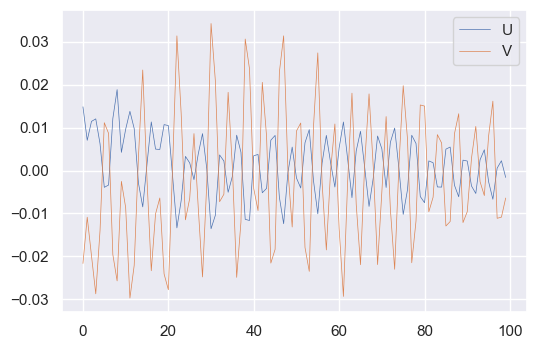

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:30<00:00,  1.02s/it]


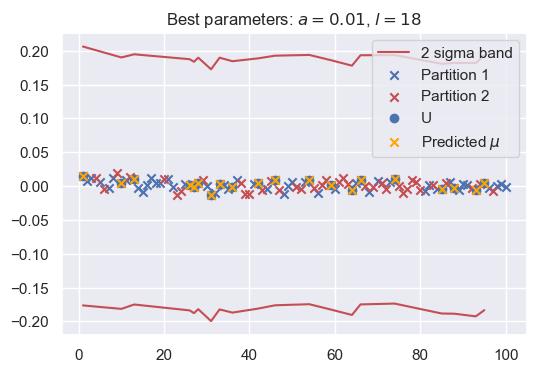

In [44]:
import numpy as  np
import matplotlib.pyplot as plt
import numpy.linalg as lalg
import scipy.stats
import tqdm

plt.close()
plt.clf()
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

U_dot = U_m[319,324,:]
V_dot = V_m[319,324,:]
x = np.arange(100)
plt.plot(x, U_dot, label="U", lw=0.5)
plt.plot(x, V_dot, label="V", lw=0.5)
plt.legend()
plt.show()

ind_x2 = np.arange(0,100,1)
perm = np.random.permutation(ind_x2.shape[0])
k1_x2, k2_x2 = [ ind_x2[a] for a in map(np.sort, np.split(perm, 2)) ]

for k_x2, label, c in [(k1_x2, "Partition 1", 'b'), (k2_x2, "Partition 2", 'r')]:
  plt.scatter(k_x2+1, U_dot[k_x2], label=label, c=c, marker='x')

x = np.arange(1,101,2)

theta1 = 0.1 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta2 = 50 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta3 = 0.97 #@param {type:"slider", min:0, max:4, step:0.01}

covs = np.arange(1,101)[:,None] - np.arange(1,101)[None,:]
a_vals = np.arange(0.0, 0.3, 0.01)
ell_vals = np.arange(7, 360, 1)

ind_x2 = np.arange(0, 100, 1)

K = 5
perm = np.random.permutation(ind_x2.shape[0])
ks_x2 = [ ind_x2[a] for a in map(np.sort, np.array_split(perm, K)) ]

tau = 1.0

target_best = -np.inf
params_best = {}

for a_param in tqdm.tqdm(a_vals):
  for ell_param in ell_vals:
    sigma = a_param * np.exp( - covs**2 / ell_param**2 )

    vals = []
    
    for k in range(K):
      x_test = ks_x2[k]
      x_train = np.sort(np.array(list(set(ind_x2) - set(x_test))))

      mu_1 = U_dot[x_test]
      mu_2 = U_dot[x_train]

      sigma_11 = sigma[x_test[:,None],x_test]
      sigma_12 = sigma[x_test[:,None],x_train]
      sigma_21 = sigma[x_train[:,None],x_test]
      sigma_22 = sigma[x_train[:,None],x_train]

      sigma_22_noise = sigma_22 + tau * np.eye(mu_2.shape[0])
      x2_2 = U_dot[x_train]

      mu_1_2 = mu_1 + sigma_12.dot( lalg.solve(sigma_22_noise, x2_2 - mu_2 ) )
      sigma_1_2 = sigma_11 - sigma_12.dot(np.linalg.solve((sigma_22_noise), np.eye(sigma_22_noise.shape[0])).dot(sigma_12.T))

      val = scipy.stats.multivariate_normal.logpdf(U_dot[x_test], mean=mu_1_2, cov=sigma_1_2,allow_singular=True)
      vals.append(val)

    total = sum(vals)

    if total > target_best:
      params_best = dict(
          a=a_param,
          ell=ell_param,
          xs=x_test+1,
          U_dot=U_dot[x_test],
          mu=mu_1_2,
          sigma=np.sqrt(np.diagonal(sigma_1_2))
      )
      target_best = total

sigma_opt = params_best['a'] * np.exp( - covs**2 / params_best['ell']**2 )
plt.scatter(params_best['xs'], params_best['U_dot'], c='b', marker='o', label="U")
plt.scatter(params_best['xs'], params_best['mu'], c='orange', marker='x', label=r"Predicted $\mu$")
plt.plot(params_best['xs'], params_best['mu'] + 2*params_best['sigma'], c='r', label="2 sigma band")
plt.plot(params_best['xs'], params_best['mu'] - 2*params_best['sigma'], c='r')
plt.title(r"Best parameters: $a={a}$, $l={ell}$".format(**params_best))
plt.legend()
plt.show()

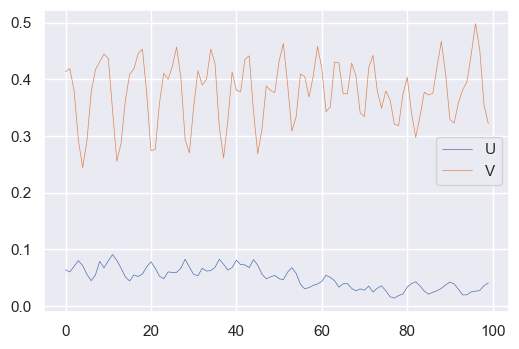

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:31<00:00,  1.04s/it]


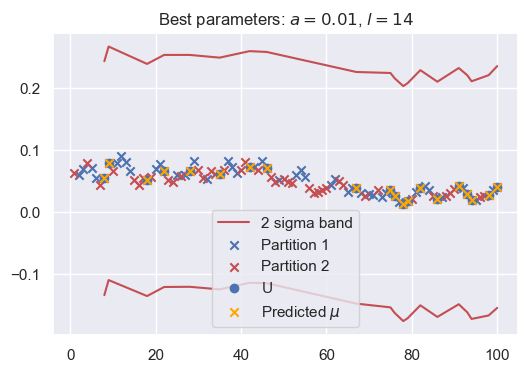

In [47]:
import numpy as  np
import matplotlib.pyplot as plt
import numpy.linalg as lalg
import scipy.stats
import tqdm

plt.close()
plt.clf()
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

U_dot = U_m[500,400,:]
V_dot = V_m[500,400,:]
x = np.arange(100)
plt.plot(x, U_dot, label="U", lw=0.5)
plt.plot(x, V_dot, label="V", lw=0.5)
plt.legend()
plt.show()

ind_x2 = np.arange(0,100,1)
perm = np.random.permutation(ind_x2.shape[0])
k1_x2, k2_x2 = [ ind_x2[a] for a in map(np.sort, np.split(perm, 2)) ]

for k_x2, label, c in [(k1_x2, "Partition 1", 'b'), (k2_x2, "Partition 2", 'r')]:
  plt.scatter(k_x2+1, U_dot[k_x2], label=label, c=c, marker='x')

x = np.arange(1,101,2)

theta1 = 0.1 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta2 = 50 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta3 = 0.97 #@param {type:"slider", min:0, max:4, step:0.01}

covs = np.arange(1,101)[:,None] - np.arange(1,101)[None,:]
a_vals = np.arange(0.0, 0.3, 0.01)
ell_vals = np.arange(7, 360, 1)

ind_x2 = np.arange(0, 100, 1)

K = 5
perm = np.random.permutation(ind_x2.shape[0])
ks_x2 = [ ind_x2[a] for a in map(np.sort, np.array_split(perm, K)) ]

tau = 1.0

target_best = -np.inf
params_best = {}

for a_param in tqdm.tqdm(a_vals):
  for ell_param in ell_vals:
    sigma = a_param * np.exp( - covs**2 / ell_param**2 )

    vals = []
    
    for k in range(K):
      x_test = ks_x2[k]
      x_train = np.sort(np.array(list(set(ind_x2) - set(x_test))))

      mu_1 = U_dot[x_test]
      mu_2 = U_dot[x_train]

      sigma_11 = sigma[x_test[:,None],x_test]
      sigma_12 = sigma[x_test[:,None],x_train]
      sigma_21 = sigma[x_train[:,None],x_test]
      sigma_22 = sigma[x_train[:,None],x_train]

      sigma_22_noise = sigma_22 + tau * np.eye(mu_2.shape[0])
      x2_2 = U_dot[x_train]

      mu_1_2 = mu_1 + sigma_12.dot( lalg.solve(sigma_22_noise, x2_2 - mu_2 ) )
      sigma_1_2 = sigma_11 - sigma_12.dot(np.linalg.solve((sigma_22_noise), np.eye(sigma_22_noise.shape[0])).dot(sigma_12.T))

      val = scipy.stats.multivariate_normal.logpdf(U_dot[x_test], mean=mu_1_2, cov=sigma_1_2,allow_singular=True)
      vals.append(val)

    total = sum(vals)

    if total > target_best:
      params_best = dict(
          a=a_param,
          ell=ell_param,
          xs=x_test+1,
          U_dot=U_dot[x_test],
          mu=mu_1_2,
          sigma=np.sqrt(np.diagonal(sigma_1_2))
      )
      target_best = total

sigma_opt = params_best['a'] * np.exp( - covs**2 / params_best['ell']**2 )
plt.scatter(params_best['xs'], params_best['U_dot'], c='b', marker='o', label="U")
plt.scatter(params_best['xs'], params_best['mu'], c='orange', marker='x', label=r"Predicted $\mu$")
plt.plot(params_best['xs'], params_best['mu'] + 2*params_best['sigma'], c='r', label="2 sigma band")
plt.plot(params_best['xs'], params_best['mu'] - 2*params_best['sigma'], c='r')
plt.title(r"Best parameters: $a={a}$, $l={ell}$".format(**params_best))
plt.legend()
plt.show()

**c.** We have suggested one particular value for $\tau$. Consider other possible values and comment on the effects such parameter has on the estimated parameters and the estimation process's performance. Try at least two values different from that used in Problem 4.a.

(1 point): Provides the optimal kernel values for at least two new choices of $\tau$.  
(2 points): A plot showing the cost/optimization target is provided for the search space, for each choice of $\tau$.  
(2 points): Comments on whether these results differ from those found in Problem 4.a, and on whether results from the choices of $\tau$ in the problem differ from each other.

### ANS
The optimal kernel values when $\tau$ = 10 and 0.1 are as follows:\
$\tau$ = 10: a = ; l = ;
$\tau$ = 0.1: a = ; l = ;
When $\tau$ is smaller, the calculation step is smaller, and the result obtained is more accurate.

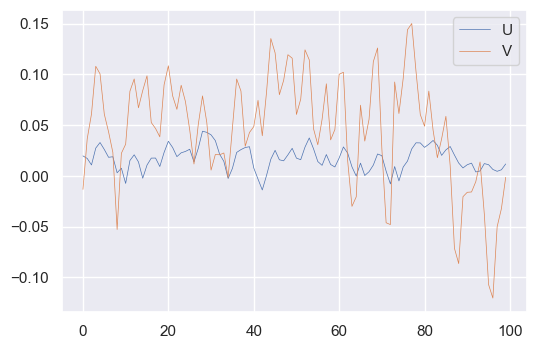

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [05:08<00:00,  1.03s/it]


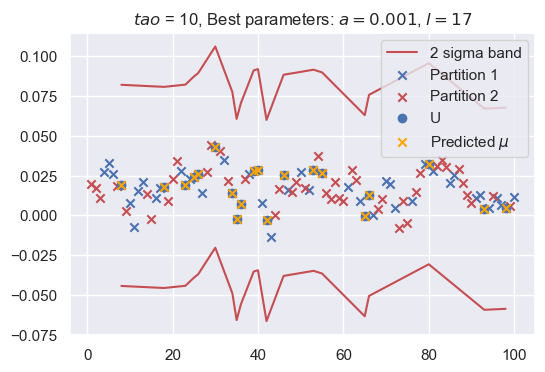

In [5]:
import numpy as  np
import matplotlib.pyplot as plt
import numpy.linalg as lalg
import scipy.stats
import tqdm

plt.close()
plt.clf()
plt.rcParams['figure.figsize'] = [6, 4]
plt.rcParams['figure.dpi'] = 100

U_dot = U_m[319,24,:]
V_dot = V_m[319,24,:]
x = np.arange(100)
plt.plot(x, U_dot, label="U", lw=0.5)
plt.plot(x, V_dot, label="V", lw=0.5)
plt.legend()
plt.show()

ind_x2 = np.arange(0,100,1)
perm = np.random.permutation(ind_x2.shape[0])
k1_x2, k2_x2 = [ ind_x2[a] for a in map(np.sort, np.split(perm, 2)) ]

for k_x2, label, c in [(k1_x2, "Partition 1", 'b'), (k2_x2, "Partition 2", 'r')]:
  plt.scatter(k_x2+1, U_dot[k_x2], label=label, c=c, marker='x')

x = np.arange(1,101,2)

theta1 = 0.1 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta2 = 50 #@param {type:"slider", min:0.1, max:10, step:0.1}
theta3 = 0.97 #@param {type:"slider", min:0, max:4, step:0.01}

covs = np.arange(1,101)[:,None] - np.arange(1,101)[None,:]
a_vals = np.arange(0.0, 0.3, 0.01)
ell_vals = np.arange(7, 360, 1)

ind_x2 = np.arange(0, 100, 1)

K = 5
perm = np.random.permutation(ind_x2.shape[0])
ks_x2 = [ ind_x2[a] for a in map(np.sort, np.array_split(perm, K)) ]

tau = 10.0

target_best = -np.inf
params_best = {}

for a_param in tqdm.tqdm(a_vals):
  for ell_param in ell_vals:
    sigma = a_param * np.exp( - covs**2 / ell_param**2 )

    vals = []
    
    for k in range(K):
      x_test = ks_x2[k]
      x_train = np.sort(np.array(list(set(ind_x2) - set(x_test))))

      mu_1 = U_dot[x_test]
      mu_2 = U_dot[x_train]

      sigma_11 = sigma[x_test[:,None],x_test]
      sigma_12 = sigma[x_test[:,None],x_train]
      sigma_21 = sigma[x_train[:,None],x_test]
      sigma_22 = sigma[x_train[:,None],x_train]

      sigma_22_noise = sigma_22 + tau * np.eye(mu_2.shape[0])
      x2_2 = U_dot[x_train]

      mu_1_2 = mu_1 + sigma_12.dot( lalg.solve(sigma_22_noise, x2_2 - mu_2 ) )
      sigma_1_2 = sigma_11 - sigma_12.dot(np.linalg.solve((sigma_22_noise), np.eye(sigma_22_noise.shape[0])).dot(sigma_12.T))

      val = scipy.stats.multivariate_normal.logpdf(U_dot[x_test], mean=mu_1_2, cov=sigma_1_2,allow_singular=True)
      vals.append(val)

    total = sum(vals)

    if total > target_best:
      params_best = dict(
          a=a_param,
          ell=ell_param,
          xs=x_test+1,
          U_dot=U_dot[x_test],
          mu=mu_1_2,
          sigma=np.sqrt(np.diagonal(sigma_1_2))
      )
      target_best = total

sigma_opt = params_best['a'] * np.exp( - covs**2 / params_best['ell']**2 )
plt.scatter(params_best['xs'], params_best['U_dot'], c='b', marker='o', label="U")
plt.scatter(params_best['xs'], params_best['mu'], c='orange', marker='x', label=r"Predicted $\mu$")
plt.plot(params_best['xs'], params_best['mu'] + 2*params_best['sigma'], c='r', label="2 sigma band")
plt.plot(params_best['xs'], params_best['mu'] - 2*params_best['sigma'], c='r')
plt.title(r"$tao$ = 10, Best parameters: $a={a}$, $l={ell}$".format(**params_best))
plt.legend()
plt.show()

**d.** Currently, most of the commonly used languages like Python, R, Matlab, etc., have pre-installed libraries for Gaussian processes. Use one library of your choice, maybe the language or environment you like the most, and compare the obtained results. Did you get the same parameters as in problem 4.a? If not, why are they different? Elaborate on your answer.

(2 points): Provides the optimal kernel parameters as found through the software library.  
(2 points): Provides details on the library used.  
(2 points): Comments on whether these results differ from those found in Problem 4.a.  
(2 points): The results are the same, or, the results are different and an explanation is provided.  
(2 points): A plot showing the cost/optimization target is provided for the search space, or a plot comparing the predictions generated (in problem 5) if the results are different.

### Problem 5: Estimating unobserved flow data  
In the previous problem, we have found a good set of parameters to model the sequence of speeds at one location as a Gaussian process. Recall that we have assumed our 100 observations came at a rate of one every three days. We are going to assume that when we advance to our simulations, we will choose a smaller time step. Thus, we need to interpolate how the flow would look like at some unobserved points.

**a.** You are given flow information every three days. Pick some time stamps in-between each observation for which to estimate the flow. For example, you want flows every day, so there will be two unknown points between two observations. You could pick only one, or more than two. Make your choice and explain why.  

Compute the conditional distribution (mean and covariance) at the time locations selected in part (a). Use the kernel parameters that you obtained in Problem 4.a, and use the same location as you did in Problem 4.a.  

For the initial estimate of the mean at the unknown time locations, you can use zero, use the average of all the observations, or take the average of the two closest observed points.  

Plot your predictions, clearly showing:

- The predicted means.  
- The predicted standard deviation as a $3\sigma$ band (three standard deviations above and below the mean).  
- The observed data points.  
    
    
- (2 points): Clearly states the choice of time-stamps at which to create predictions, and states why the choice was made.  
- (2 points): Clearly states the method by which the prior means were chosen.  
- (2 points): Provides a plot with a prediction for the horizontal velocity component at the chosen location.  
- (2 points): Provides a plot with a prediction for the vertical velocity component at the chosen location.  
- (3 points): Both plots have a labelled prediction for the mean for all of the time-stamps chosen.  
- (3 points): Both plots have a labelled $3\sigma$ band around the predicted mean for all of the time-stamps chosen.  
- (1 point): Both plots have the observations included.

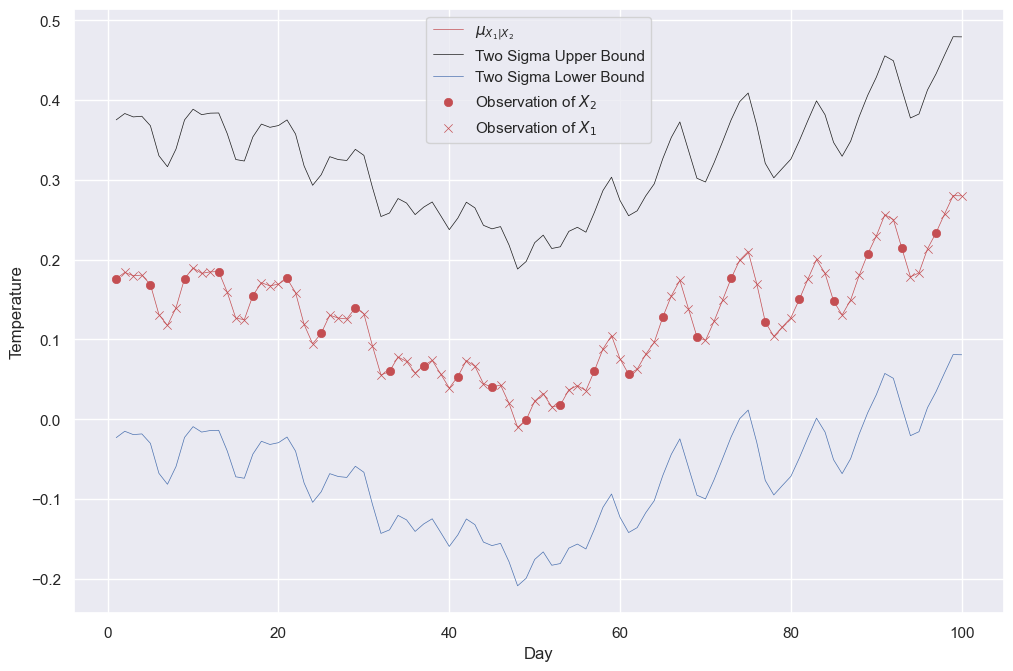

In [20]:
ind_x2 = np.arange(0, 100,4)
ind_x1 = np.array(sorted(list(set(np.arange(0, 100)) - set(ind_x2))))

# First  separate the components of the covariance matrix
sigma_11_n = sigma_opt[ind_x1[:,None],ind_x1];
sigma_12_n = sigma_opt[ind_x1[:,None],ind_x2];
sigma_21_n = sigma_opt[ind_x2[:,None],ind_x1];
sigma_22_n = sigma_opt[ind_x2[:,None],ind_x2];

U_dot1 = U_m[319,24,:]
mu_x1 = U_dot1[ind_x1]
mu_x2 = U_dot1[ind_x2]

tau = 10.0

sigma_22_n_noise = sigma_22_n + tau * np.eye(mu_x2.shape[0])
x2 = U_dot1[ind_x2]

mu_x1_n = mu_x1 + sigma_12_n.dot( lalg.solve(sigma_22_n_noise, x2 - mu_x2 ) )
mu_x2_n = mu_x2 + sigma_22_n.dot( lalg.solve(sigma_22_n_noise, x2 - mu_x2 ) )

sigma_x1_n = sigma_11_n - sigma_12_n.dot(lalg.inv(sigma_22_n_noise).dot(sigma_12_n.T))
sigma_x2_n = sigma_22_n - sigma_22_n.dot(lalg.inv(sigma_22_n_noise).dot(sigma_22_n.T))

new_mu = np.zeros(100)
new_mu[ind_x1] = mu_x1_n
new_mu[ind_x2] = mu_x2_n

new_sigma = np.zeros(100)
new_sigma[ind_x1] = np.sqrt(np.diagonal(sigma_x1_n))
new_sigma[ind_x2] = np.sqrt(np.diagonal(sigma_x2_n))

xs = np.arange(1, 101)
plt.figure(figsize=(12,8))
plt.plot(xs, new_mu, c='r', label=r"$\mu_{X_1 | X_2}$", lw=0.5)
plt.plot(xs, new_mu + 2*new_sigma, c='k', label="Two Sigma Upper Bound", lw=0.5)
plt.plot(xs, new_mu - 2*new_sigma, c='b', label="Two Sigma Lower Bound", lw=0.5)
plt.scatter(ind_x2+1, U_dot[ind_x2], c='r', marker='o', label="Observation of $X_2$", lw=0.5)
plt.scatter(ind_x1+1, U_dot[ind_x1], c='r', marker='x', label="Observation of $X_1$", lw=0.5)
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend()
plt.show()

### Problem 6: A longer time-scale simulation  
In the previous problems, we learned to model the flow at one location as a Gaussian process. Thus, we can extend this to estimate the flow at any point in time at that particular location using the kernel function parameters. At a certain point in time, the flow can be computed as the realization of a multivariate Gaussian random variable with parameters given by the conditional distributions given the flow data. At this point, you are asked to simulate a particle moving according to the flow data and using the estimates for times between the original timestamps of the problem.  

Ideally, one would have to estimate the parameters of the flow at every point in the map. However, having to run $504 \times 555$ parameter selection models seems like much computational work. So, here we take a more straightforward approach: use your results from Problem 4.b to choose a value of your kernel parameters that is generally representative of the points that you tested.

**a.** Modify the simulator that you built in Problem 3.3 to use this new flow estimated flow information. Note that with this new change, you will be able to simulate the flow of particles for 300 days! Regarding data, originally, we have 100 measurements per point, now with this approach, let us say you use the estimates for two extra points to get one flow data per day, so in total, you should have at your disposal 300 descriptions of flow per location.  

Now repeat Problem 3 (b). This time you will be simulating flows for 300 days. This allows some debris to arrive on land. Where are some possible places along the coast where one could find debris? Again, to do this, pick some Ïƒ of your choice, and simulate the movement of particles with initial location sampled from the bivariate Gaussian. Evolve the location of the particles. Some times particles trajectories will terminate on the shore. Continue to keep track of such particles. These points are likely where you could find the debris.  

Provide a plot that includes your initial, final, and at least one intermediate state of your simulation. For the final state, clearly mark one location on land where you would search for debris. Also mark one location over the ocean where you would search for debris. Provide a brief justification for both choices.  

Try at least one other value for $\sigma$, and create the same three plots. Comment if your conclusions should change.  

- (2 points): Provides a plot with the initial state of the simulation.  
- (2 points): Provides a plot with an intermediate state of the simulation.  
- (2 points): Provides a plot with the final state of the simulation.  
- (2 points): Marks a location **on the coast** of the final state of the simulation where one should search for debris and provides a justification.  
- (2 points): Marks a location **over the ocean** of the final state of the simulation where one should search for debris and provides a justification.  
- (5 points): Provides three plots (initial, intermediate, final) for one other choice of $\sigma$, and comments on results (either to state why conclusions should change or why they should not).

**b.** As a final stage, you are tasked with locating three new monitoring stations on the coast. The purpose of these stations is to monitor general ocean debris. Using the tools you have build in this homework, propose the location of such three new stations. Simulate the trajectories of as many particles as you want, initialized at random locations uniformly distributed on the map. This is essentially a repeat of Problem 3 (a) with the new simulation; this time, remove particles that start on land so that they do not confuse your conclusions.  

Many of the particles will end up on the coast. A good location for a monitoring station will be areas where many of such particles land on the coast.  

Provide a plot that includes your initial, final, and at least one intermediate state of your simulation. For the final state, clearly mark where you would place your three monitoring stations. Provide a justification for why you chose these locations.  

- (2 points): Provides a plot with the initial state of the simulation, there should be no particles on land.  
- (2 points): Provides a plot with an intermediate state of the simulation.  
- (2 points): Provides a plot with the final state of the simulation.  
- (4 points): Marks three locations on the final state of the simulation where monitoring stations should be placed.  
- (4 points): Provides a convincing explanation for choosing these locations.